## The Classification Problem

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = pd.read_csv('C:/Users/vince/Downloads/bank-full.csv', delimiter=';')
#convert target variable to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


### Data Pre-Proccessing

##### Missing Data

Checking the data for having any N/A values

In [3]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Even though the data has no N/A values, it does have some of the categorical values labelled by unknown...I will check their frequency, and accordingly, I will deal with columns where such label is dominant

In [4]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(df[column].value_counts())
        print('\n')


job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64


education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64


default
no     44396
yes      815
Name: count, dtype: int64


housing
yes    25130
no     20081
Name: count, dtype: int64


loan
no     37967
yes     7244
Name: count, dtype: int64


contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64


month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64


poutcome
unknown    36959
failure 

The column "poutcome," representing the outcome of the previous marketing campaign, has approximately 90% of values labeled as unknown. Realistically speaking, such data is unattainable. Additionally, the "contact" column, which denotes the contact method used to reach the customer, contains about 30% unknown values. After considering the option of imputing this data, I believe it would be meaningless, as the majority of the non-missing labels are cellular, with only 6% being telephone. Not only is data missing in that column, but the available data is nearly all the same label. Therefore, I will be deleting the two aforementioned columns.

In [5]:
df = df.drop(['contact','poutcome'], axis=1)

##### MultiCollinearity

I will now check if any of the features are highly correlated which may lead to model multicollinearity

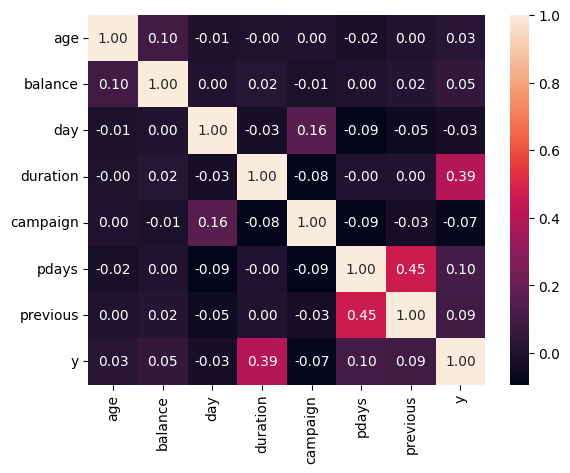

In [6]:
#get all numerical columns
df_num = df.select_dtypes(include=['int64'])
sns.heatmap(df_num.corr(), annot=True, fmt='.2f')
plt.show()


In [7]:
#using the VIF score to check for collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_num = df_num.drop('y', axis=1)
vif_data = pd.DataFrame()
vif_data["Variable"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(df_num.columns))]
#find columns with high vif > 4
high_vif_columns = vif_data[(vif_data['VIF'] > 3.5) & np.isfinite(vif_data['VIF'])]['Variable'] 
display(vif_data)

print("Columns with a high VIF score > 3.5: ", high_vif_columns.values)

,Variable,VIF
0,age,5.004058
1,balance,1.212908
2,day,3.984268
3,duration,1.901309
4,campaign,1.824694
5,pdays,1.454202
6,previous,1.341641


Columns with a high VIF score > 3.5:  ['age' 'day']


I was able to find out that the age and day columns both have a VIF score > 3.5, which means that those may both contribute to the multicollinearity of the model. Since, according to the above printed correlation matrix, days hardly has any correlation with the target variable, I will be deleting it and re-running the VIF test to check if the multicollinearity issue would still persist

In [8]:
#using the VIF score to check for collinearity
df_num = df_num.drop('day', axis=1)
vif_data = pd.DataFrame()
vif_data["Variable"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(df_num.columns))]
#find columns with high vif > 4
high_vif_columns = vif_data[(vif_data['VIF'] > 3.5) & np.isfinite(vif_data['VIF'])]['Variable'] 
display(vif_data)

print("Columns with a high VIF score > 3.5: ", high_vif_columns.values)

,Variable,VIF
0,age,3.001308
1,balance,1.212681
2,duration,1.885498
3,campaign,1.720985
4,pdays,1.453987
5,previous,1.341515


Columns with a high VIF score > 3.5:  []


All the columns now have a VIF score lower than 3.5, thus I will now go to the next step in data pre-proccessing

##### Categorical Variables

I will now be converting binary categorical variables to 0-1 binary variables, and multi-class categorical variables will be one hot encoded.

In [9]:
#show all categorical columns
df_cat = df.select_dtypes(include=['object'])
df_cat

,job,marital,education,default,housing,loan,month
0,management,married,tertiary,no,yes,no,may
1,technician,single,secondary,no,yes,no,may
2,entrepreneur,married,secondary,no,yes,yes,may
3,blue-collar,married,unknown,no,yes,no,may
4,unknown,single,unknown,no,no,no,may
...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,nov
45207,retired,divorced,primary,no,no,no,nov
45208,retired,married,secondary,no,no,no,nov
45209,blue-collar,married,secondary,no,no,no,nov


In [10]:
# convert binary variables to 0 and 1
df['default'] = df['default'].map({'yes': 1, 'no': 0}).astype(int)
df['housing'] = df['housing'].map({'yes': 1, 'no': 0}).astype(int)
df['loan'] = df['loan'].map({'yes': 1, 'no': 0}).astype(int)

#dummify multi-class categorical variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'month'])
df

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,0,2143,1,0,5,261,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
1,44,0,29,1,0,5,151,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
2,33,0,2,1,1,5,76,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
3,47,0,1506,1,0,5,92,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
4,33,0,1,0,0,5,198,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,False,False,False,False,False,False,False,True,False,False
45207,71,0,1729,0,0,17,456,2,-1,0,...,False,False,False,False,False,False,False,True,False,False
45208,72,0,5715,0,0,17,1127,5,184,3,...,False,False,False,False,False,False,False,True,False,False
45209,57,0,668,0,0,17,508,4,-1,0,...,False,False,False,False,False,False,False,True,False,False


##### Splitting Data into Training and Test

In [11]:
#split data into training and testing
from sklearn.model_selection import train_test_split
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

##### Outlier Detection:

I will now work on detecting and eliminating outliers in the data using an isolation forest

In [12]:
##### Outlier Detection:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=.05, random_state=0)
pred = iforest.fit_predict(training_data)
# Extracting anomalies
from numpy import where
anomaly_index = where(pred==-1) #-1 is the label for anomalies
anomaly_values = training_data.iloc[anomaly_index]
# Removing anomalies
training_data = training_data.drop(anomaly_values.index)
print("Number of outliers found:", len(anomaly_values))

Number of outliers found: 1809


##### Feature Engineering

I will now employ LASSO regression in an attempt to question the neccesity of having all of the features in the model

In [13]:
from sklearn.linear_model import Lasso

ls = Lasso(alpha=0.01)
X = training_data.drop('y', axis=1)
y = training_data['y']
ls.fit(X, y)
ls.coef_

coef = pd.DataFrame(ls.coef_, index=X.columns, columns=['Coefficient'])
display(coef)

,Coefficient
age,-0.000750
default,-0.000000
balance,0.000002
housing,-0.037725
loan,-0.000000
day,-0.000290
duration,0.000438
campaign,-0.001661
pdays,0.000215
previous,0.002918


I will test the performance of a random forest on the original training features and the LASSO suggested features

In [14]:
#import random forest
from sklearn.ensemble import RandomForestClassifier
#decision tree
from sklearn.metrics import accuracy_score

#train random forest model
rf = RandomForestClassifier(random_state=2)
rf.fit(X, y)
#cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Cross validation scores of random forest on full feature set :", scores.mean())

#train random forest model on lasso reduced 
Xtraining_data_LASSO = X[coef[coef['Coefficient'] != 0].index]
Xtesting_data_LASSO = X_test[coef[coef['Coefficient'] != 0].index]

rf = RandomForestClassifier(random_state=2)
rf.fit(Xtraining_data_LASSO, y)
#cross val
scores = cross_val_score(rf, Xtraining_data_LASSO, y, cv=5, scoring='accuracy')
print("Cross validation scores of random forest on LASSO reduced feature set :", scores.mean())


Cross validation scores of random forest on full feature set : 0.915655284844318
Cross validation scores of random forest on LASSO reduced feature set : 0.91030010645203


As can be seen above, the random forest accuracy with the lasso reduced features does not differ much from the accuracy of the random forest with the all features; in fact, the lasso reduced features random forest performs slightly worse, thus I will keep using the full dataset.

##### Class Imbalance

I will now ensure that the dataset does not have a class imbalance in the target variable

Percentage of the target variable:
y
0    90.721499
1     9.278501
Name: proportion, dtype: float64


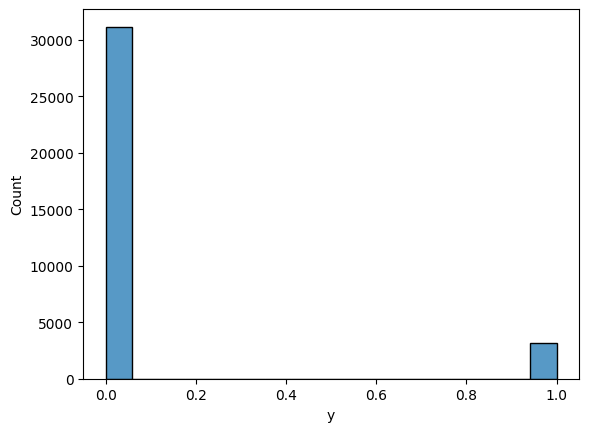

In [15]:
#plot the histogram of the target variable
sns.histplot(training_data['y'])
print("Percentage of the target variable:")
print(training_data['y'].value_counts(normalize=True) * 100)

There is a clear class imbalance where most of the rows are for instances where the client did not register for a term deposit, and only 9% of the rows represent clients registering for the deposit. Thus, I will be oversampling the minority class, which is clients regestering for a term deposit.

In [16]:
from imblearn.over_sampling import RandomOverSampler

df_copy = training_data.copy()
X = df_copy.drop('y', axis=1)
y = df_copy['y']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
df_copy = pd.concat([X_resampled, y_resampled], axis=1)
print(df_copy['y'].value_counts())
df_copy



y
0    31171
1    31171
Name: count, dtype: int64


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,41,0,849,1,0,15,72,1,-1,0,...,False,False,False,False,False,True,False,False,False,0
1,49,0,1415,1,0,30,269,2,-1,0,...,False,False,True,False,False,False,False,False,False,0
2,42,0,3842,0,0,31,130,4,-1,0,...,False,False,True,False,False,False,False,False,False,0
3,37,0,-119,1,0,11,375,11,-1,0,...,False,False,False,True,False,False,False,False,False,0
4,56,0,3498,0,0,15,264,2,-1,0,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62337,49,0,249,0,0,6,234,1,-1,0,...,False,False,False,False,False,False,True,False,False,1
62338,35,0,520,1,0,4,458,3,17,5,...,False,False,False,False,False,True,False,False,False,1
62339,33,0,4,1,1,18,625,2,-1,0,...,False,False,False,True,False,False,False,False,False,1
62340,44,0,348,1,1,16,170,2,-1,0,...,True,False,False,False,False,False,False,False,False,1


##### Data Scaling:

I am now creating a new version of the dataset with scaling applied. I have chosen to use the MinMax scaler since my current dataset contains many binary (0-1) variables, and I want to preserve their distribution.

In [17]:
#standardize the data using minmax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = df_copy.drop('y', axis=1)
y = df_copy['y']
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df_copy.drop('y', axis=1).columns)
Xt = scaler.transform(X_test)
Xt = pd.DataFrame(Xt, columns=X.columns)

##### Datasets to be used in modelling

Non-Scaled Dataset

In [18]:
X_train = df_copy.drop('y', axis=1)
y_train = df_copy['y']

X_test = X_test.copy()
y_test = y_test.copy()

Scaled Dataset

In [19]:
X_train_std = X
y_train_std = y_train.copy()

X_test_std = Xt
y_test_std = y_test.copy()

### Model Building

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model on the scaled training data
logreg.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred = logreg.predict(X_test_std)

# Calculate metrics
accuracy = accuracy_score(y_test_std, y_pred)
precision = precision_score(y_test_std, y_pred)
recall = recall_score(y_test_std, y_pred)
f1 = f1_score(y_test_std, y_pred)
roc_auc = roc_auc_score(y_test_std, y_pred)



C:\Users\vince\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
